<a href="https://colab.research.google.com/github/gaws15/AINotebooksVault/blob/main/image02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

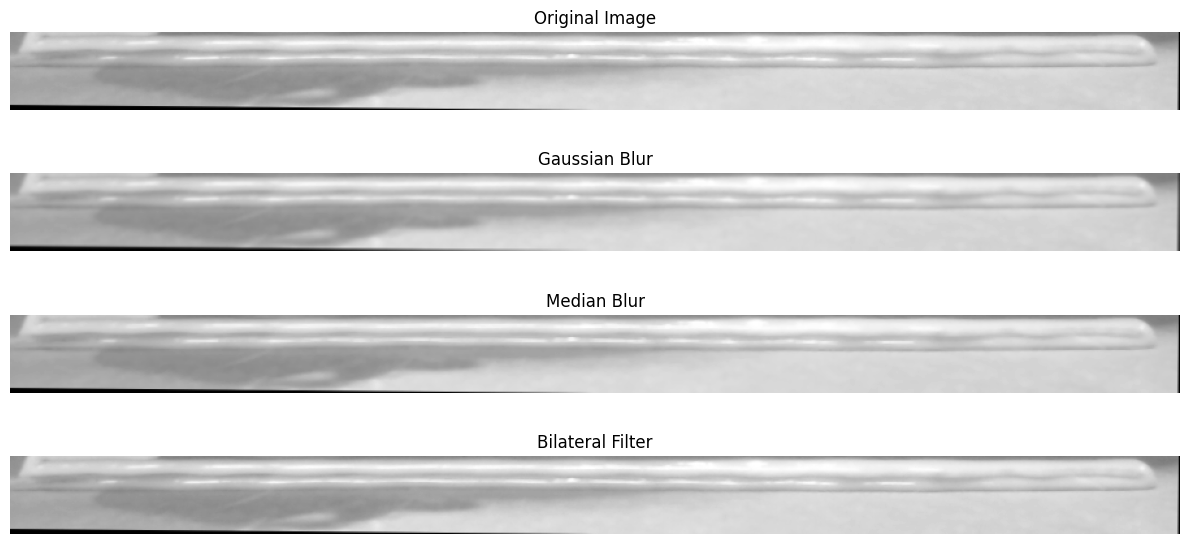

In [64]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import skeletonize

# Read the image
img = cv2.imread('/content/rotated_frame_3_cropped2.jpg', 0)  # 0 for grayscale
# Get the dimensions of the image
height, width = img.shape[:2]

# Calculate the new dimensions (half size)
new_height = height // 2
new_width = width // 2

# Resize the image
img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

kernel_size=(3, 3)
  # Apply Gaussian Blur
gaussian_blur = cv2.GaussianBlur(img, kernel_size, 0)

    # Apply Median Blur
median_blur = cv2.medianBlur(img, kernel_size[0])  # Kernel size is a single value for medianBlur

    # Apply Bilateral Filter
bilateral_blur = cv2.bilateralFilter(img, 9, 75, 75)
normalize = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(4, 1, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(4, 1, 2)
plt.imshow(gaussian_blur, cmap='gray')
plt.title('Gaussian Blur')
plt.axis('off')

plt.subplot(4, 1, 3)
plt.imshow(median_blur, cmap='gray')
plt.title('Median Blur')
plt.axis('off')

plt.subplot(4, 1, 4)
plt.imshow(normalize, cmap='gray')
plt.title('Bilateral Filter')
plt.axis('off')

plt.tight_layout()
plt.show()

############## 4 farklı filtreleme operasyonu yapılıp içinden median blur ile devam edilmiştir.

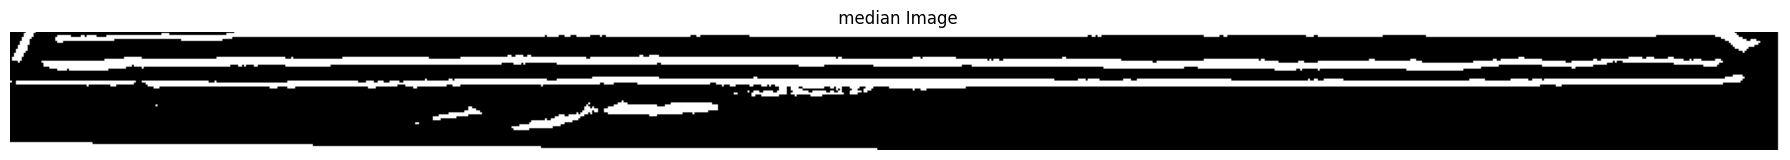

In [97]:
from skimage.morphology import skeletonize # This line likely already exists in the beginning of your notebook

# Apply adaptive thresholding on the blurred image
thresh1 = cv2.adaptiveThreshold(median_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 25, 8)

# Display setup
fig, (ax1) = plt.subplots(1, 1, figsize=(18, 6))

ax1.imshow(thresh1, cmap='gray')
ax1.set_title(' median Image')
ax1.axis('off')


plt.tight_layout()
plt.show()

median masking

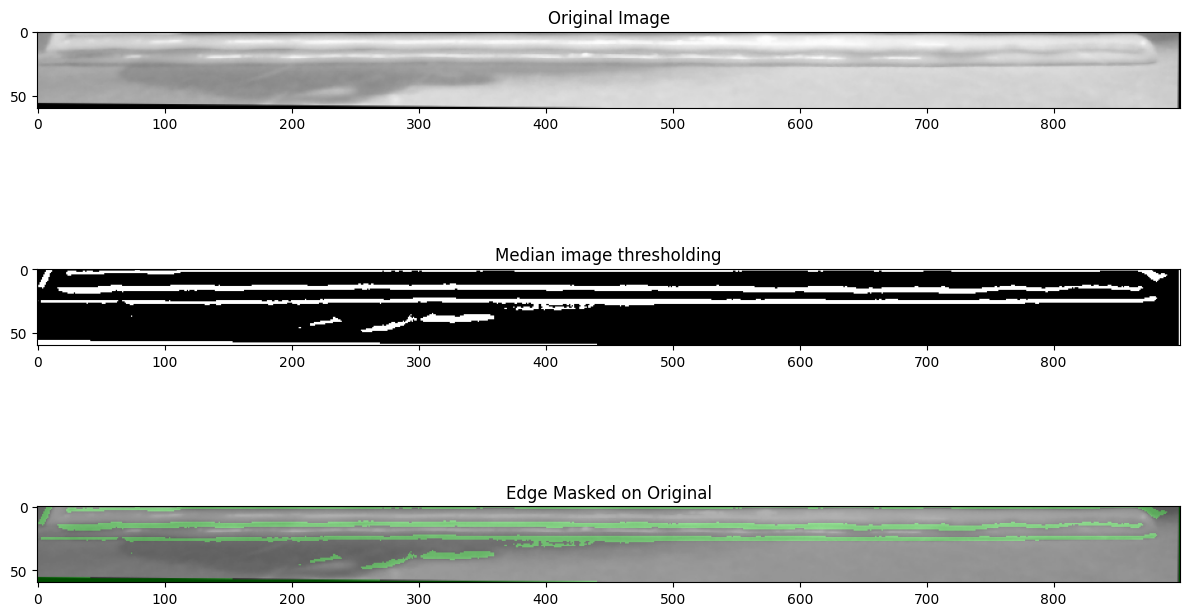

In [98]:

mask = np.zeros_like(img)  # Since img is already a 3-channel image

# Mark edges in green on the 3-channel mask
mask[thresh1 != 0] = [0, 255, 0]  # Use != 0 to catch all non-zero edge pixels


# Overlay the mask on the original image
# Convert img to 3 channels if it's not already
#if len(img.shape) == 2:  # Check if img is grayscale  --this part is not required anymore
#    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

masked_image = cv2.addWeighted(img, 0.7, mask, 0.3, 0)

# Visualization
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(3, 1, 2)
plt.title('Median image thresholding')
plt.imshow(thresh1, cmap='gray')

plt.subplot(3, 1, 3)
plt.title('Edge Masked on Original')
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()


diğer thinning--skeletonizing methods

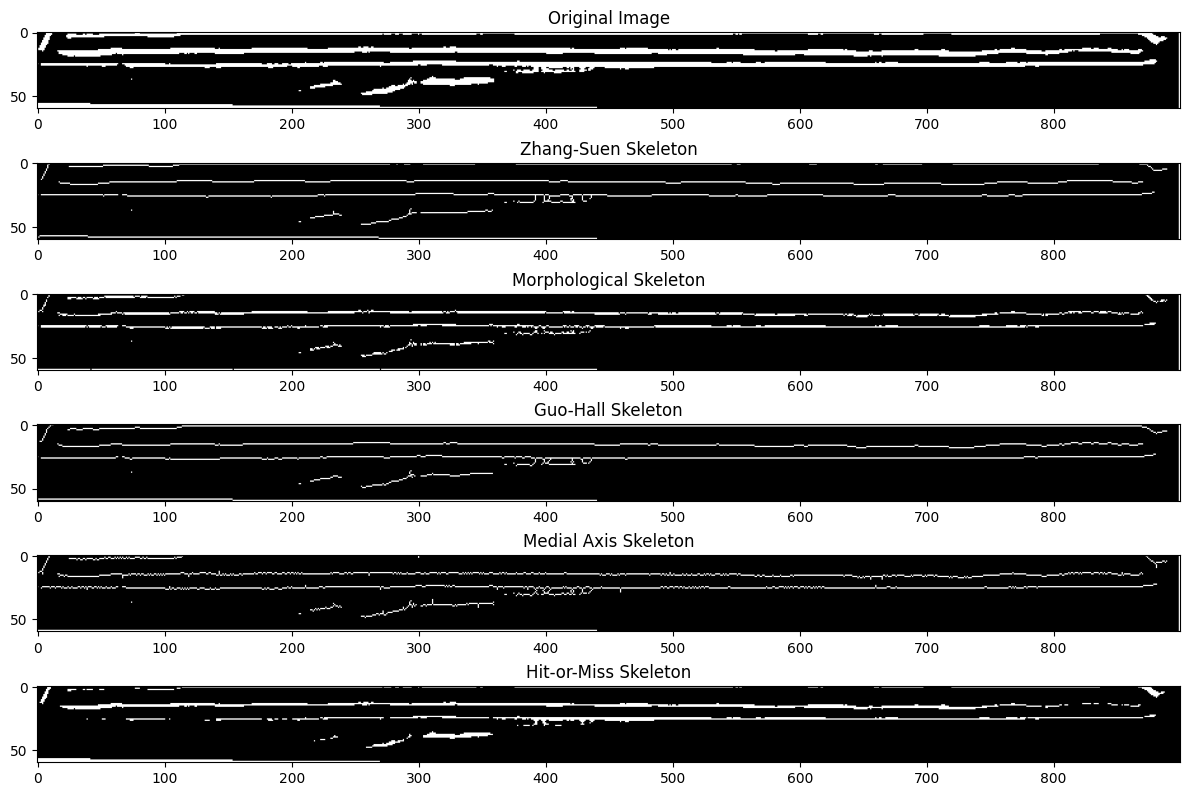

In [99]:
import cv2
import numpy as np
from skimage.morphology import skeletonize, thin, medial_axis
import matplotlib.pyplot as plt


# Convert to 0 or 1 for skimage
binary = thresh1 // 255

# 1. Zhang-Suen Skeletonization
zhang_suen = skeletonize(binary)
zhang_suen = (zhang_suen * 255).astype(np.uint8)

# 2. Morphological Skeleton (OpenCV)
def morphological_skeleton(img):
    size = np.size(img)
    skeleton = np.zeros(img.shape, np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

    while True:
        eroded = cv2.erode(img, kernel)
        temp = cv2.dilate(eroded, kernel)
        temp = cv2.subtract(img, temp)
        skeleton = cv2.bitwise_or(skeleton, temp)
        img = eroded.copy()
        if cv2.countNonZero(img) == 0:
            break
    return skeleton

morph_skel = morphological_skeleton(binary * 255)

# 3. Guo-Hall Thinning

thin_guo_hall = thin(thresh1)  # Remove max_iter argument
thin_guo_hall = (thin_guo_hall * 255).astype(np.uint8)

# 4. Medial Axis Skeletonization
medial_skel, distance = medial_axis(binary, return_distance=True)
medial_skel = (medial_skel * 255).astype(np.uint8)

# 5. Hit-or-Miss Skeletonization
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
hit_miss_skel = cv2.morphologyEx(binary * 255, cv2.MORPH_HITMISS, kernel)

# Visualization
plt.figure(figsize=(12, 8))

plt.subplot(6, 1, 1)
plt.title('Original Image')
plt.imshow(binary * 255, cmap='gray')

plt.subplot(6, 1, 2)
plt.title('Zhang-Suen Skeleton')
plt.imshow(zhang_suen, cmap='gray')

plt.subplot(6, 1, 3)
plt.title('Morphological Skeleton')
plt.imshow(morph_skel, cmap='gray')

plt.subplot(6, 1, 4)
plt.title('Guo-Hall Skeleton')
plt.imshow(thin_guo_hall, cmap='gray')

plt.subplot(6, 1, 5)
plt.title('Medial Axis Skeleton')
plt.imshow(medial_skel, cmap='gray')

plt.subplot(6, 1, 6)
plt.title('Hit-or-Miss Skeleton')
plt.imshow(hit_miss_skel, cmap='gray')

plt.tight_layout()
plt.show()


In [67]:
# sampling and calculation -zhang-Suen Skeletonisation

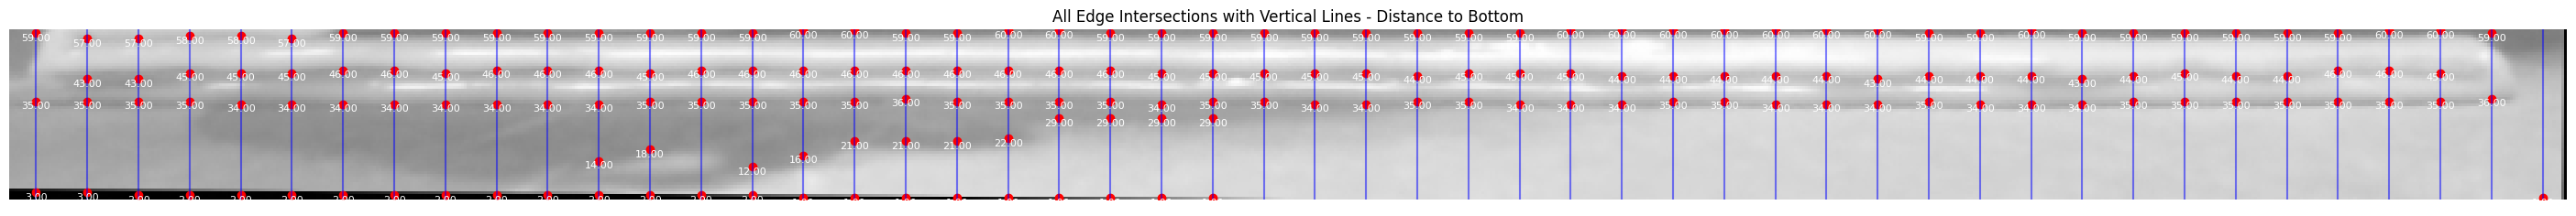

In [101]:
# 1. Zhang-Suen Skeletonization
# Divide vertically into 50 segments
# Image dimensions
height, width = hit_miss_skel.shape

divisions = 50
all_points = []

for i in range(divisions):
    x = int((i + 0.5) * width / divisions)  # +0.5 to center the line in each division
    local_points = []

    for y in range(height):
        if zhang_suen[y, x] > 0:  # Assuming edges are represented by positive values
            local_points.append((x, y))

    # If no edges found, add one point at the bottom
    if not local_points:
        local_points.append((x, height - 1))

    all_points.extend(local_points)

# Visualization
plt.figure(figsize=(36, 12))
plt.imshow(img, cmap='gray')

# Plot all points
for x, y in all_points:
    plt.plot(x, y, 'ro')  # red dot for each intersection point

# Draw vertical lines for each division
for i in range(divisions):
    x = int((i + 0.5) * width / divisions)
    plt.axvline(x, color='b', alpha=0.5)  # Blue vertical lines

# Measure and annotate distance from each point to the bottom
for x, y in all_points:
    distance = height - y  # Measure from the point to the bottom
    plt.text(x, y, f'{distance:.2f}', color='white', fontsize=8, ha='center', va='top')  # va='top' to position text above point

plt.title('All Edge Intersections with Vertical Lines - Distance to Bottom')
plt.axis('off')
plt.show()



masking operation ans see the line on the original image   ---verification

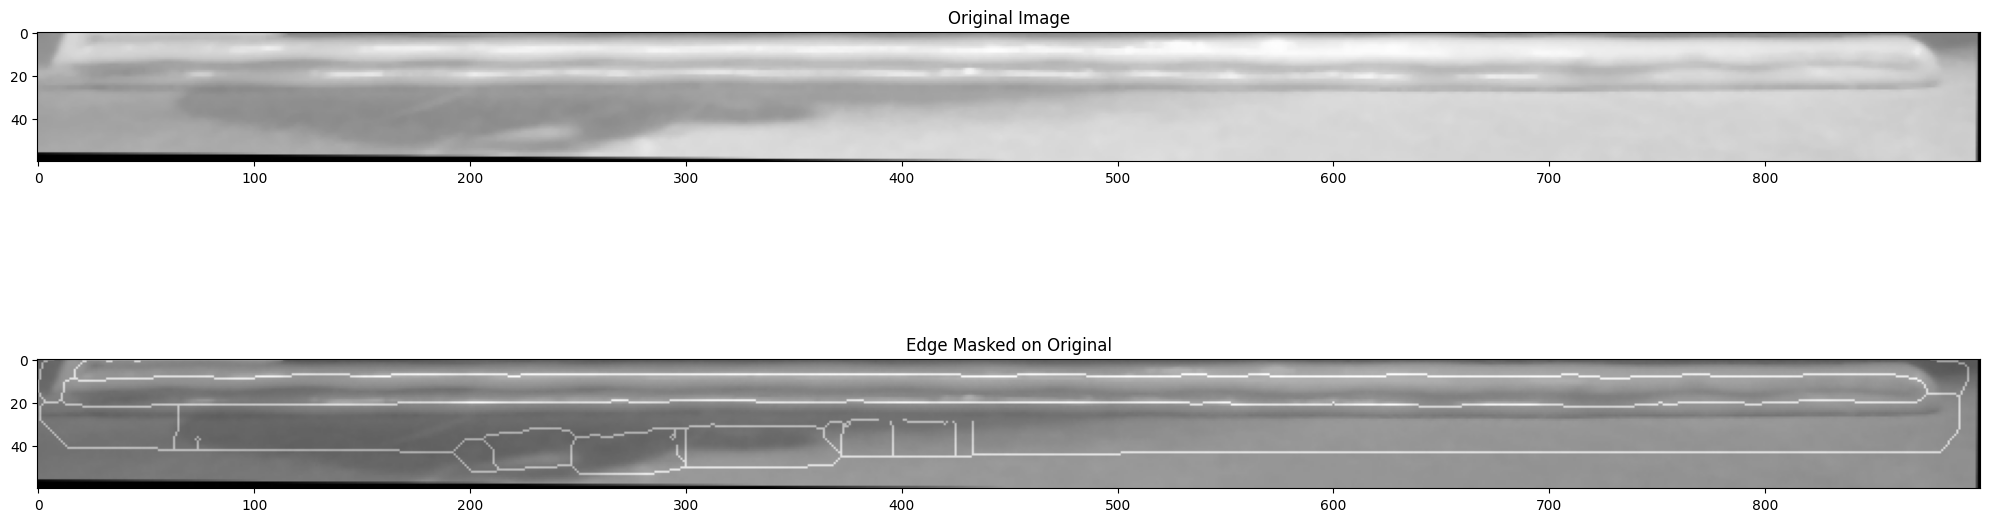

In [77]:
# Create mask from skeleton with 3 channels
mask = np.zeros_like(img, dtype=np.uint8)  # Ensure dtype is uint8 for color image

# Convert the mask to BGR format
mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)  # Convert to 3 channels

# Now you can assign the color to the mask (still grayscale):
mask[zhang_suen == 255] = 255  # Mark edges in white (or any grayscale value)

# Overlay the mask on the original image
# Since both are grayscale now, addWeighted should work
masked_image = cv2.addWeighted(img, 0.7, mask[:,:,0], 0.3, 0) #Use only one channel from mask

# Now you can assign the color to the mask:
mask[zhang_suen == 255] = [0, 255, 0]  # Mark edges in green


# Visualization
plt.figure(figsize=(20, 8))

plt.subplot(2, 1, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(median_blur, cv2.COLOR_BGR2RGB))

plt.subplot(2, 1, 2)
plt.title('Edge Masked on Original')
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()

canny deneme

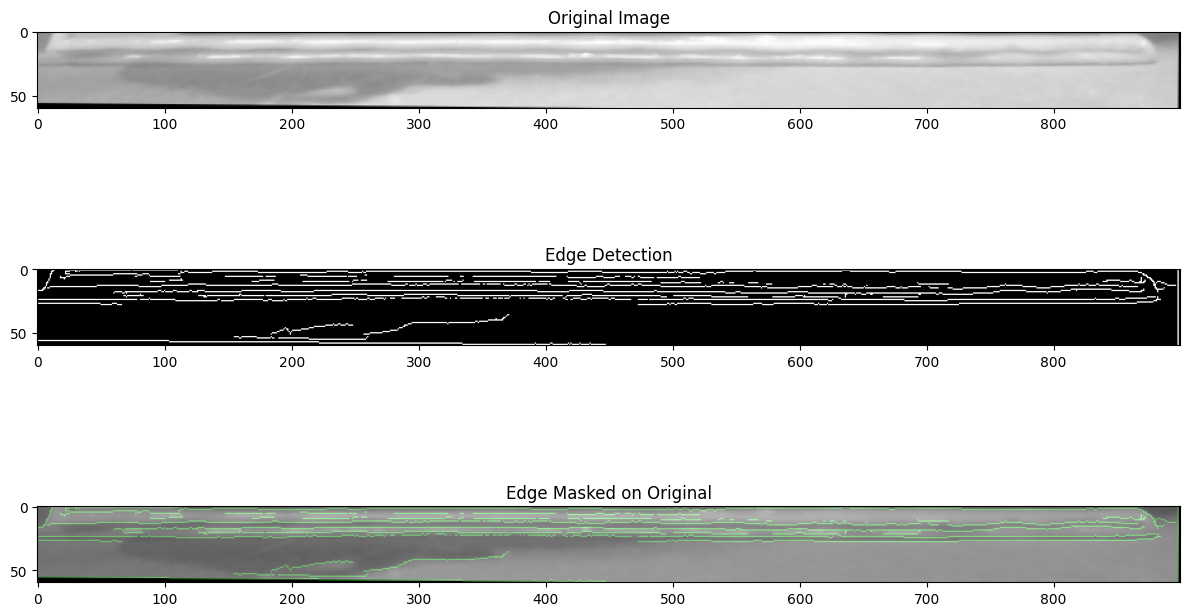

In [93]:

# Apply Canny Edge Detection
edges = cv2.Canny(median_blur, 20, 80)

# Create a 3-channel mask (or use img directly if it's already 3-channel)
#mask = np.zeros_like(img, dtype=np.uint8)  # Ensure dtype is uint8 for color image
#mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)  # Convert to 3 channels  --removed this line as it was causing the error

mask = np.zeros_like(img)  # Since img is already a 3-channel image

# Mark edges in green on the 3-channel mask
mask[edges != 0] = [0, 255, 0]  # Use != 0 to catch all non-zero edge pixels


# Overlay the mask on the original image
# Convert img to 3 channels if it's not already
#if len(img.shape) == 2:  # Check if img is grayscale  --this part is not required anymore
#    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

masked_image = cv2.addWeighted(img, 0.7, mask, 0.3, 0)

# Visualization
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(3, 1, 2)
plt.title('Edge Detection')
plt.imshow(edges, cmap='gray')

plt.subplot(3, 1, 3)
plt.title('Edge Masked on Original')
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()

